## Importazione librerie

In [83]:
import pandas as pd
import folium
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans

## Caricamento dati

In [84]:
# Caricamento dei dati dai file CSV
df_fastfood = pd.read_csv('datasets/fastfood.csv')
df_pollution = pd.read_csv('datasets/pollution.csv')
df_geo = pd.read_csv('datasets/US_GeoCode.csv')
df_heart = pd.read_csv('datasets/heart_2018.csv')

# Selezione di subset dei dati
df_subset_fastfood = df_fastfood[["num", "State", "latitude", "longitude", "name"]]
df_subset_pollution = df_pollution[["Year", "State", "O3 Mean", "CO Mean", "SO2 Mean", "NO2 Mean"]]
df_subset_GEO = df_geo[["latitude", "longitude", "State"]]
df_subset_heart = df_heart[["YEAR", "State", "RATE", "DEATHS"]]

# Dizionario per mappare le sigle delle province ai loro nomi completi
province_mapping = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California", "CO": "Colorado",
    "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine",
    "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico",
    "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon",
    "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington", "WV": "West Virginia",
    "WI": "Wisconsin", "WY": "Wyoming"
}

# Sostituisci le sigle delle province con i loro nomi completi
df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)
df_subset_pollution = df_pollution[['State', 'O3 Mean']]

# Aggregazione dei dati
fastfood_count = df_subset_fastfood.groupby('State').size().reset_index(name='fastfood_count')
pollution_mean = df_subset_pollution.groupby('State').mean().reset_index()

# Unione dei dati
data = df_subset_heart.merge(fastfood_count, on='State').merge(pollution_mean, on='State')

/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1003/876043998.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1003/876043998.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)


## Analisi reti

### Rete dei fast food per stato
- Ogni nodo rappresenta un fast food e contiene le sue coordinate geografiche (latitudine e longitudine). Questi nodi sono contrassegnati dal tipo "fastfood".
- Ogni nodo rappresenta uno stato degli Stati Uniti. Questi nodi sono contrassegnati dal tipo "state".
- Gli archi connettono i fast food agli stati in cui sono situati. Ad esempio, se un fast food si trova in un certo stato, ci sarà un arco che collega il nodo del fast food al nodo dello stato corrispondente.

In [85]:
# Conta il numero di stati in cui è presente ciascuna catena di fast food
fastfood_state_counts = df_subset_fastfood.groupby('name')['State'].nunique()

# Ordina le catene di fast food in base al numero di stati in cui sono presenti
popular_fastfood = fastfood_state_counts.sort_values(ascending=False)

# Visualizza le catene di fast food più popolari
print(popular_fastfood)

name
Taco Bell                       49
McDonald's                      48
Burger King                     46
Wendy's                         45
Subway                          44
                                ..
Garden Catering                  1
Gangnam Style Korean Kitchen     1
Gambino's Pizza                  1
GD Bro Burger                    1
iSushi                           1
Name: State, Length: 571, dtype: int64


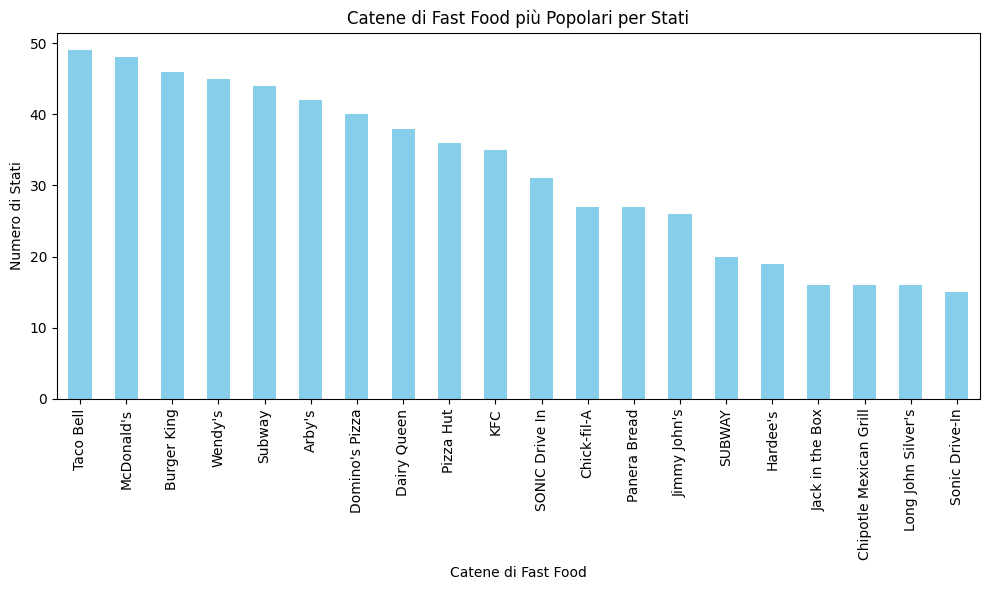

In [86]:
# Impostazioni per il grafico
plt.figure(figsize=(10, 6))

# Creazione del grafico a barre
(popular_fastfood.head(20)).plot(kind='bar', color='skyblue')

# Titoli e label
plt.title('Catene di Fast Food più Popolari per Stati')
plt.xlabel('Catene di Fast Food')
plt.ylabel('Numero di Stati')

# Mostra il grafico
plt.tight_layout()
plt.show()


#### Filtraggio

In [87]:
# Conteggio delle presenze di ciascuna catena di fast food negli stati
fastfood_presence = df_fastfood.groupby('name')['State'].nunique().sort_values(ascending=False)

# Seleziona solo le prime 20 catene di fast food più popolari
top_fastfood = fastfood_presence.head(20).index

# Filtra il DataFrame dei fast food tenendo solo le prime 20 catene più popolari
df_subset_fastfood_top = df_fastfood[df_fastfood['name'].isin(top_fastfood)]

In [88]:
# Creazione della rete dei fast food per stato
G_fastfood_top = nx.Graph()
for index, row in df_subset_fastfood_top.iterrows():
    G_fastfood_top.add_node(row['name'], type='fastfood', latitude=row['latitude'], longitude=row['longitude'])
    G_fastfood_top.add_node(row['State'], type='state')
    G_fastfood_top.add_edge(row['name'], row['State'])

In [89]:
# Stampa i dettagli dei nodi per verificare le coordinate
print("Dettagli dei nodi:")
for node, data in G_fastfood_top.nodes(data=True):
    print(node, data)

Dettagli dei nodi:
SONIC Drive In {'type': 'fastfood', 'latitude': 35.37719, 'longitude': -118.91516}
LA {'type': 'state'}
Taco Bell {'type': 'fastfood', 'latitude': 39.86891, 'longitude': -84.29297}
TN {'type': 'state'}
Arby's {'type': 'fastfood', 'latitude': 32.581842, 'longitude': -93.24889}
Wendy's {'type': 'fastfood', 'latitude': 39.8291, 'longitude': -84.0253}
MI {'type': 'state'}
Burger King {'type': 'fastfood', 'latitude': 32.32756, 'longitude': -111.04825}
Chipotle Mexican Grill {'type': 'fastfood', 'latitude': 39.59723846, 'longitude': -84.2314274}
CA {'type': 'state'}
Dairy Queen {'type': 'fastfood', 'latitude': 61.613815, 'longitude': -149.06532}
TX {'type': 'state'}
McDonald's {'type': 'fastfood', 'latitude': 34.18063, 'longitude': -119.16498}
NY {'type': 'state'}
MA {'type': 'state'}
MO {'type': 'state'}
GA {'type': 'state'}
OH {'type': 'state'}
Jack in the Box {'type': 'fastfood', 'latitude': 34.1551, 'longitude': -119.1952}
SC {'type': 'state'}
CT {'type': 'state'}
KY {

- La rete è visualizzata su una mappa interattiva degli Stati Uniti. 
- I fast food sono rappresentati da marcatori blu sulla mappa.

In [90]:
# Crea la mappa centrata sugli Stati Uniti
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Aggiungi la mappa degli Stati Uniti come base
folium.TileLayer('cartodbpositron').add_to(m)

# Aggiungi i marker per i fast food
for node, data in G_fastfood_top.nodes(data=True):
    # Assicurati che il nodo sia un fast food e che abbia le coordinate
    if data['type'] == 'fastfood':
        if 'latitude' in data and 'longitude' in data:
            # Ottieni le coordinate del fast food dal grafo
            coordinates = (data['latitude'], data['longitude'])
            # Aggiungi il marker sulla mappa
            folium.Marker(
                location=coordinates,
                popup=node,  # Mostra il nome del fast food quando si clicca sul marker
                icon=folium.Icon(color='blue')
            ).add_to(m)
        else:
            print(f"Nodo {node} di tipo fastfood non ha le coordinate.")

# Aggiungi i polilinea per gli archi
for edge in G_fastfood_top.edges():
    node1, node2 = edge
    data1 = G_fastfood_top.nodes[node1]
    data2 = G_fastfood_top.nodes[node2]
    # Verifica se gli attributi latitude e longitude sono presenti nei nodi
    if 'latitude' in data1 and 'longitude' in data1 and 'latitude' in data2 and 'longitude' in data2:
        # Ottieni le coordinate dei nodi collegati
        coordinates_source = (data1['latitude'], data1['longitude'])
        coordinates_target = (data2['latitude'], data2['longitude'])
        # Aggiungi la polilinea alla mappa
        folium.PolyLine([coordinates_source, coordinates_target], color='gray').add_to(m)

# Visualizza la mappa
m

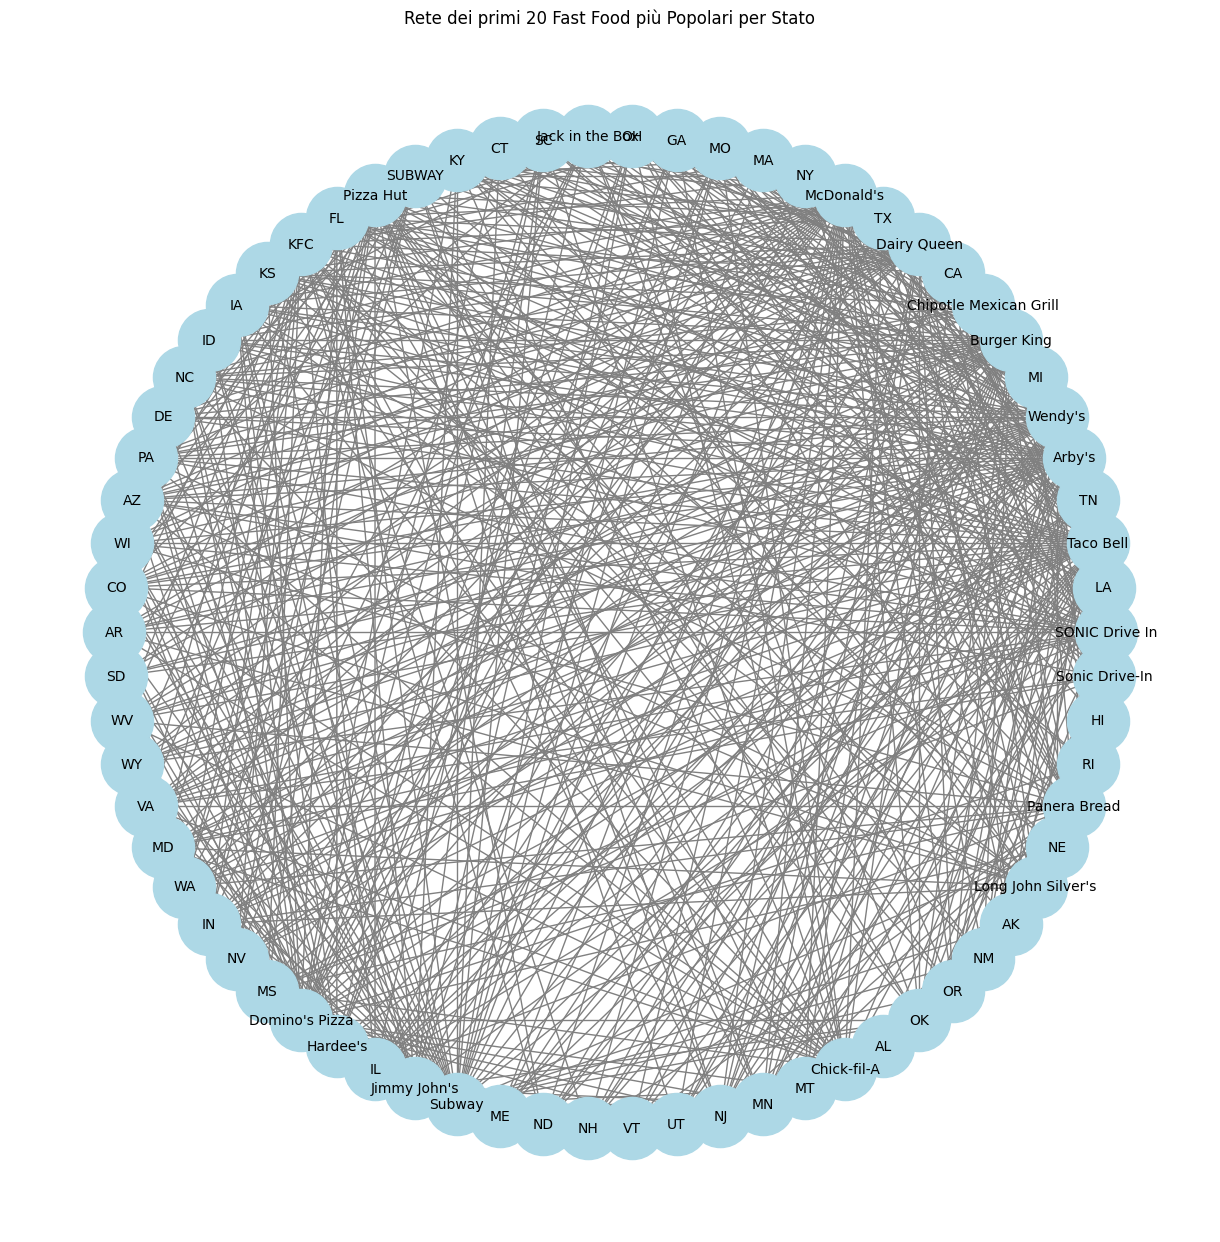

In [91]:
# Visualizzazione della rete con layout circolare
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G_fastfood_top)
nx.draw(G_fastfood_top, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete dei primi 20 Fast Food più Popolari per Stato')
plt.show()

In [92]:
# Debug: Verifica dei nodi e delle loro coordinate
for node in G_fastfood_top.nodes(data=True):
    print(node)

('SONIC Drive In', {'type': 'fastfood', 'latitude': 35.37719, 'longitude': -118.91516})
('LA', {'type': 'state'})
('Taco Bell', {'type': 'fastfood', 'latitude': 39.86891, 'longitude': -84.29297})
('TN', {'type': 'state'})
("Arby's", {'type': 'fastfood', 'latitude': 32.581842, 'longitude': -93.24889})
("Wendy's", {'type': 'fastfood', 'latitude': 39.8291, 'longitude': -84.0253})
('MI', {'type': 'state'})
('Burger King', {'type': 'fastfood', 'latitude': 32.32756, 'longitude': -111.04825})
('Chipotle Mexican Grill', {'type': 'fastfood', 'latitude': 39.59723846, 'longitude': -84.2314274})
('CA', {'type': 'state'})
('Dairy Queen', {'type': 'fastfood', 'latitude': 61.613815, 'longitude': -149.06532})
('TX', {'type': 'state'})
("McDonald's", {'type': 'fastfood', 'latitude': 34.18063, 'longitude': -119.16498})
('NY', {'type': 'state'})
('MA', {'type': 'state'})
('MO', {'type': 'state'})
('GA', {'type': 'state'})
('OH', {'type': 'state'})
('Jack in the Box', {'type': 'fastfood', 'latitude': 34.1

### Rete dell'inquinamento per stato:

- I nodi rappresentano gli stati.
- Ogni nodo ha un attributo ozone_mean, che indica il livello medio di ozono in quel particolare stato.
- Gli archi sono stati aggiunti in base alla differenza dei valori medi dell'ozono tra due stati:
    se la differenza dei valori medi dell'ozono tra due stati è inferiore a una soglia predefinita, viene aggiunto un arco tra quei due stati.

In [93]:
# Calcola la media dell'ozono per stato
average_ozone_by_state = df_subset_pollution.groupby('State')['O3 Mean'].mean().reset_index()

# Crea il grafo
G_pollution = nx.Graph()

# Aggiungi i nodi per gli stati
for index, row in average_ozone_by_state.iterrows():
    G_pollution.add_node(row['State'], ozone_mean=row['O3 Mean'])

threshold = 5  # Esempio di soglia

# Aggiungi gli archi basati sulla differenza dei valori medi dell'ozono
for i in range(len(average_ozone_by_state)):
    for j in range(i+1, len(average_ozone_by_state)):
        state1 = average_ozone_by_state.iloc[i]['State']
        state2 = average_ozone_by_state.iloc[j]['State']
        ozone1 = average_ozone_by_state.iloc[i]['O3 Mean']
        ozone2 = average_ozone_by_state.iloc[j]['O3 Mean']
        if abs(ozone1 - ozone2) < threshold:
            G_pollution.add_edge(state1, state2)


La rete è visualizzata utilizzando un layout a molla per distribuire i nodi in modo ottimale sulla visualizzazione.
La dimensione dei nodi è proporzionale alla loro centralità, mentre il colore dei nodi indica il livello medio di ozono in ciascuno stato (più chiara è la tonalità di verde, più basso è il livello di ozono).

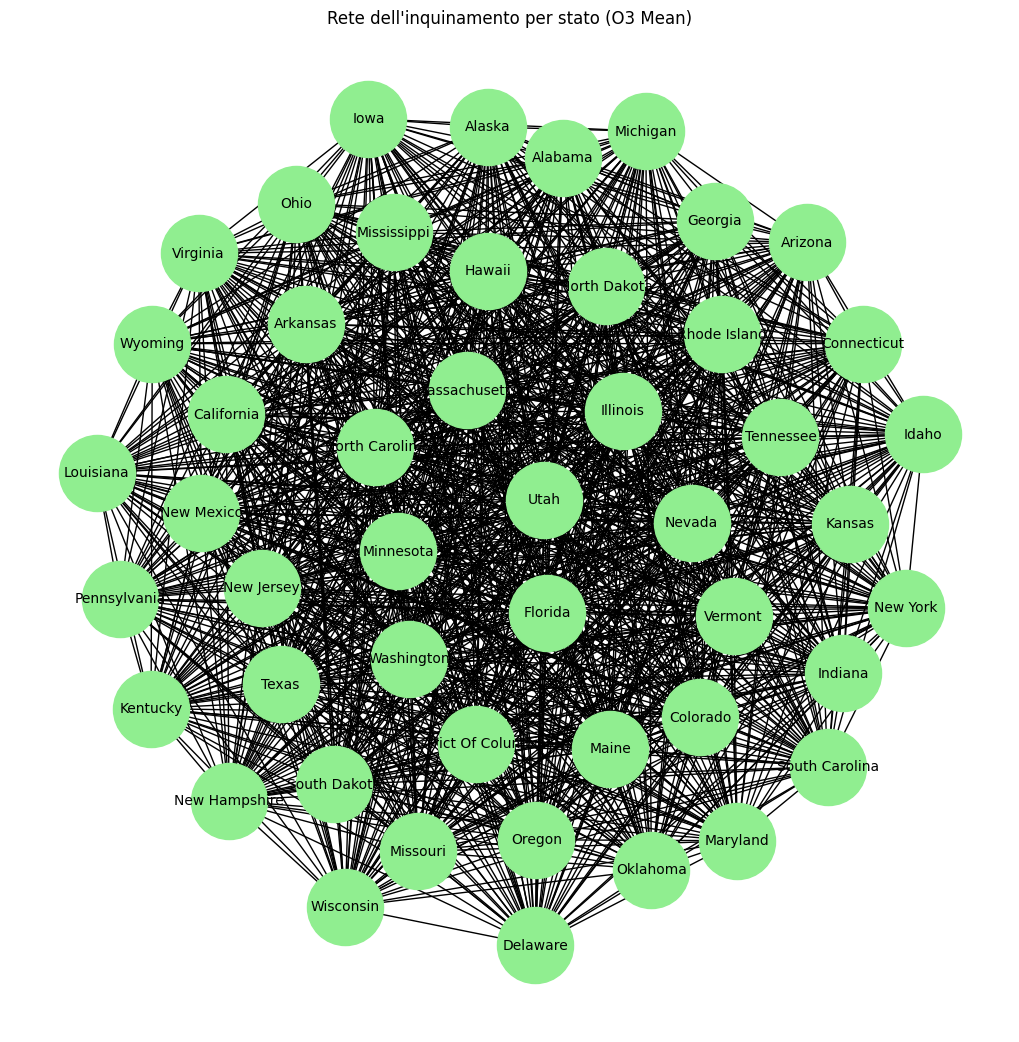

In [94]:
# Visualizza la rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_pollution)
nx.draw(G_pollution, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10)
plt.title('Rete dell\'inquinamento per stato (O3 Mean)')
plt.show()


### Rete degli attacchi di cuore per stato:

- Ogni nodo nella rete rappresenta uno stato degli Stati Uniti. 
- I nodi sono stati ottenuti dai dati relativi agli attacchi di cuore, con l'attributo aggiuntivo type impostato su "state" per identificare il tipo di nodo.
- Gli archi sono stati aggiunti in base alla similitudine dei tassi di attacchi di cuore tra 2 stati. Hai impostato una soglia di similitudine, con una differenza massima di 10 tra i tassi di attacchi di cuore per considerare due stati simili. Se la differenza tra i tassi di attacchi di cuore di due stati è inferiore alla soglia definita, viene aggiunto un arco tra quei due stati.

In [95]:
# Creazione della rete degli attacchi di cuore per stato
G_heart = nx.Graph()
for index, row in df_subset_heart.iterrows():
    G_heart.add_node(row['State'], type='state')


# Definisci una soglia per la similitudine
threshold = 10  # Differenza massima tra i tassi di attacchi di cuore per considerare due stati simili

# Aggiungi gli archi basati sulla similitudine dei tassi di attacchi di cuore
for i in range(len(df_subset_heart)):
    for j in range(i+1, len(df_subset_heart)):
        state1 = df_subset_heart.iloc[i]['State']
        state2 = df_subset_heart.iloc[j]['State']
        rate1 = df_subset_heart.iloc[i]['RATE']
        rate2 = df_subset_heart.iloc[j]['RATE']
        if abs(rate1 - rate2) < threshold:
            G_heart.add_edge(state1, state2)


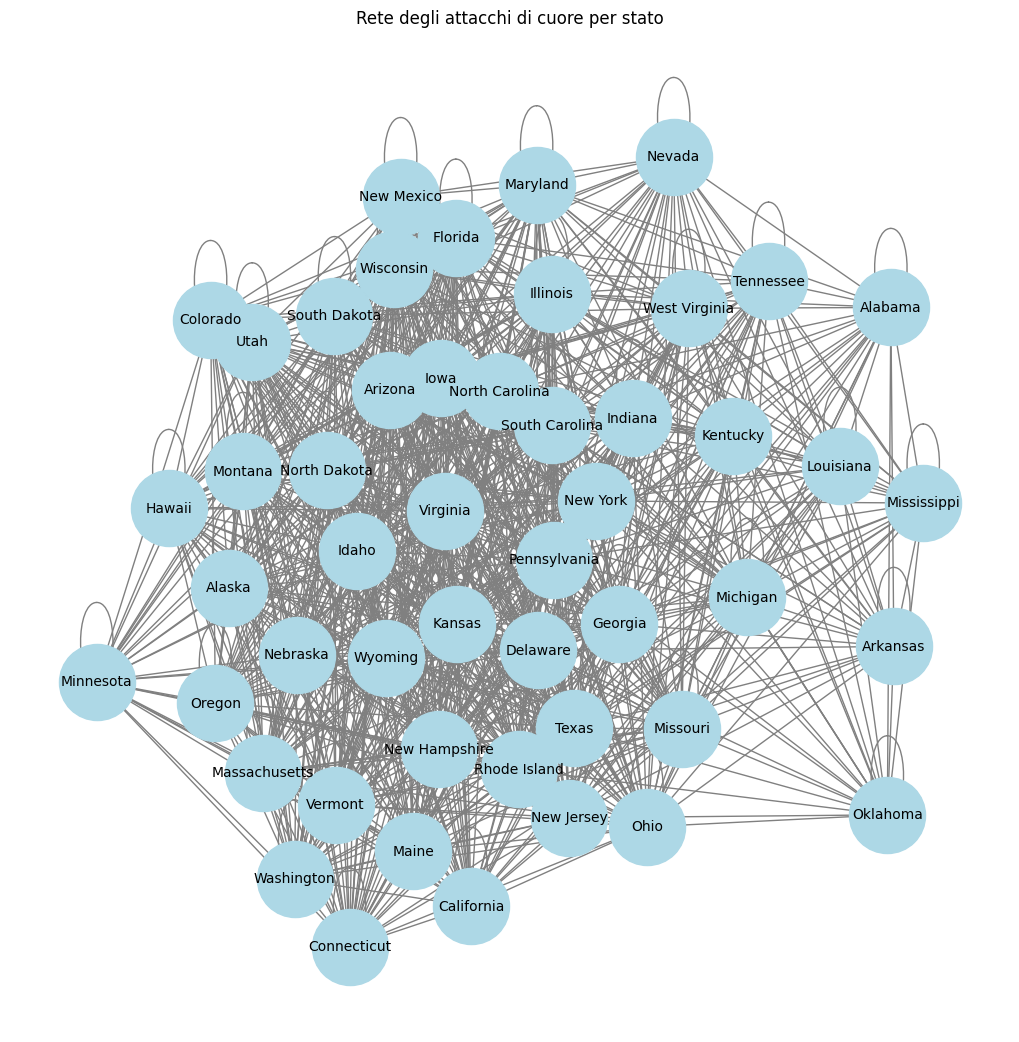

In [96]:
# Visualizzazione della rete
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_heart)  # Posizionamento dei nodi
nx.draw(G_heart, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete degli attacchi di cuore per stato')
plt.show()

### Rete di correlazione tra attacchi di cuore e fast food
- Ogni nodo nella rete rappresenta uno stato degli Stati Uniti. 
- I nodi sono stati ottenuti dai dati combinati relativi agli attacchi di cuore e alla presenza di fast food, con l'attributo aggiuntivo type impostato su "state" per identificare il tipo di nodo. 
- Ogni nodo include anche informazioni sul tasso di attacchi di cuore (rate) e sul conteggio dei fast food presenti (fastfood_count).
- Gli archi sono stati aggiunti in base alla similitudine dei tassi di attacchi di cuore e del numero di fast food tra 2 stati. Abbiamo definito due soglie di similitudine: 
1. una per la differenza massima nei tassi di attacchi di cuore (threshold_rate) 
2. una per la differenza massima nel numero di fast food (threshold_fastfood). 

Se la differenza tra i tassi di attacchi di cuore e il numero di fast food di due stati è inferiore alle soglie definite, viene aggiunto un arco tra quei due stati.

In [98]:
# Creazione della rete di correlazione tra attacchi di cuore e fast food
G_heart_fastfood = nx.Graph()
for state, attributes in data.items():
    G_heart_fastfood.add_node(row['State'], type='state', rate=row['RATE'], fastfood_count=row['fastfood_count'])

# Definisci una soglia per la similitudine
threshold_rate = 10  # Differenza massima tra i tassi di attacchi di cuore per considerare due stati simili
threshold_fastfood = 20  # Differenza massima tra il numero di fast food per considerare due stati simili

# Aggiungi gli archi basati sulla similitudine dei tassi di attacchi di cuore e del numero di fast food
for i in range(len(data)):
    for j in range(i+1, len(data)):
        state1 = data.iloc[i]['State']
        state2 = data.iloc[j]['State']
        rate1 = data.iloc[i]['RATE']
        rate2 = data.iloc[j]['RATE']
        fastfood_count1 = data.iloc[i]['fastfood_count']
        fastfood_count2 = data.iloc[j]['fastfood_count']
        if abs(rate1 - rate2) < threshold_rate and abs(fastfood_count1 - fastfood_count2) < threshold_fastfood:
            G_heart_fastfood.add_edge(state1, state2)


KeyError: 'fastfood_count'

In [ ]:
# Visualizzazione della rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_heart_fastfood)  # Posizionamento dei nodi
nx.draw(G_heart_fastfood, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete di correlazione tra attacchi di cuore e fast food')
plt.show()

### Rete di correlazione tra attacchi di cuore e inquinamento
- I nodi nella rete rappresentano gli stati degli Stati Uniti. 
- Ogni nodo contiene informazioni sull'attributo type, impostato su "state" per identificare il tipo di nodo, il tasso di attacchi di cuore (rate) e il livello medio di ozono (o3_mean).
- Gli archi sono stati aggiunti in base alla similitudine nei tassi di attacchi di cuore e nei livelli di inquinamento atmosferico (ozono) tra due stati. Abbiamo definito due soglie di similitudine: 
1. una per la differenza massima nei tassi di attacchi di cuore (threshold_rate) 
2. una per la differenza massima nei livelli di ozono (threshold_ozone). 

Se la differenza tra i tassi di attacchi di cuore e i livelli di ozono di due stati è inferiore alle soglie definite, viene aggiunto un arco tra quei due stati.


In [ ]:
# Creazione della rete di correlazione tra attacchi di cuore e inquinamento
G_heart_pollution = nx.Graph()
for index, row in data.iterrows():
    G_heart_pollution.add_node(row['State'], type='state', rate=row['RATE'], o3_mean=row['O3 Mean'])

# Definisci una soglia per la similitudine
threshold_rate = 10  # Differenza massima tra i tassi di attacchi di cuore per considerare due stati simili
threshold_ozone = 5  # Differenza massima tra i livelli di O3 per considerare due stati simili

# Aggiungi gli archi basati sulla similitudine dei tassi di attacchi di cuore e dei livelli di inquinamento
for i in range(len(data)):
    for j in range(i+1, len(data)):
        state1 = data.iloc[i]['State']
        state2 = data.iloc[j]['State']
        rate1 = data.iloc[i]['RATE']
        rate2 = data.iloc[j]['RATE']
        ozone1 = data.iloc[i]['O3 Mean']
        ozone2 = data.iloc[j]['O3 Mean']
        if abs(rate1 - rate2) < threshold_rate and abs(ozone1 - ozone2) < threshold_ozone:
            G_heart_pollution.add_edge(state1, state2)


In [ ]:
# Visualizzazione della rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_heart_pollution)  # Posizionamento dei nodi
nx.draw(G_heart_pollution, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Rete di correlazione tra attacchi di cuore e inquinamento')
plt.show()

### Rete di correlazione tra fast food, inquinamento e attacchi di cuore:

- Potresti creare una rete che collega i fast food, i livelli di inquinamento e gli attacchi di cuore.
- Potresti utilizzare le informazioni geografiche dal DataFrame df_geo per associare i dati alle posizioni geografiche corrispondenti.

In [ ]:
# Creazione di una rete che collega i fast food, i livelli di inquinamento e gli attacchi di cuore
G_combined = nx.Graph()

# Aggiunta dei nodi per i fast food
for index, row in df_subset_fastfood.iterrows():
    G_combined.add_node(row['name'], type='fast_food', latitude=row['latitude'], longitude=row['longitude'])

# Aggiunta dei nodi per gli stati
for index, row in df_subset_GEO.iterrows():
    G_combined.add_node(row['State'], type='state', latitude=row['latitude'], longitude=row['longitude'])

# Aggiunta dei nodi per i dati di inquinamento
for index, row in df_subset_pollution.iterrows():
    G_combined.add_node(row['State'], type='pollution')

# Aggiunta dei nodi per i dati sugli attacchi di cuore
for index, row in df_subset_heart.iterrows():
    G_combined.add_node(row['State'], type='heart_attack')

# Aggiunta degli archi per collegare i nodi
# Puoi definire tu come creare questi collegamenti in base alle relazioni tra i diversi tipi di dati

# Ad esempio, potresti collegare i fast food agli stati in base alla loro presenza, e gli stati ai dati di inquinamento e attacchi di cuore.
# Oppure potresti aggiungere archi che rappresentano relazioni di similitudine o correlazione tra i diversi nodi.

# Aggiungi archi tra i fast food e gli stati
for index, row in df_subset_fastfood.iterrows():
    G_combined.add_edge(row['name'], row['State'])

# Aggiungi archi tra gli stati e i dati di inquinamento
for index, row in df_subset_pollution.iterrows():
    G_combined.add_edge(row['State'], row['State'], type='pollution_data')

# Aggiungi archi tra gli stati e i dati sugli attacchi di cuore
for index, row in df_subset_heart.iterrows():
    G_combined.add_edge(row['State'], row['State'], type='heart_attack_data')

In [ ]:
# Visualizzazione della rete
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_combined)  # Posizionamento dei nodi
nx.draw(G_combined, pos, with_labels=True, node_size=3000, font_size=10)
plt.title('Rete di correlazione tra fast food, inquinamento e attacchi di cuore')
plt.show()

# Misure di analisi delle reti

### Applicazione delle misure di analisi delle reti alla rete dei fast food per stato

In [ ]:
# Calcolo della centralità di grado
degree_centrality = nx.degree_centrality(G_fastfood_top)

# Calcolo della centralità di betweenness
betweenness_centrality = nx.betweenness_centrality(G_fastfood_top)

# Calcolo del coefficiente di clustering
clustering_coefficient = nx.clustering(G_fastfood_top)

# Spiegazione delle misure
print("Centralità di grado:")
print("La centralità di grado indica quanti collegamenti entranti o uscenti ha un nodo.")
print("In una rete sociale, nodi con alta centralità di grado potrebbero essere individui molto connessi.")
print()

print("Centralità di betweenness:")
print("La centralità di betweenness misura la quantità di controllo che un nodo ha sul flusso di informazioni nella rete.")
print("In una rete di trasporto, nodi con alta centralità di betweenness potrebbero essere importanti per il flusso di traffico.")
print()

print("Coefficiente di clustering:")
print("Il coefficiente di clustering misura quanto i vicini di un nodo sono connessi tra loro.")
print("In una rete sociale, un alto coefficiente di clustering potrebbe indicare la presenza di gruppi o comunità di individui che interagiscono frequentemente tra loro.")


### Applicazione delle misure di analisi delle reti alla rete dell'inquinamento per stato

### Applicazione delle misure di analisi delle reti alla rete degli attacchi di cuore per stato

### Applicazione delle misure di analisi delle reti alla rete di correlazione tra attacchi di cuore e fast food o inquinamento